# fNIRS Data Analysis with MNE Python

### Adapted from Tutorials and Webinars by MNE creator Rob Luke

## Loading Some Packages & Running Some Functions

In [1]:
#Importing some packages
import mne
import mne_nirs
import numpy as np #different ways of importing 

In [2]:
#Part 2
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels, 
                               picks_pair_to_idx)
from nilearn.plotting import plot_design_matrix

In [3]:
#Testing running a function
np.zeros(4)

array([0., 0., 0., 0.])

In [5]:
#Set defaults using a function
mne.viz.set_3d_backend("notebook")

Using notebook 3d backend.



In [6]:
%matplotlib inline

## Loading fNIRS Data

In [7]:
import os
import matplotlib.pyplot as plt

In [8]:
#Download example data from MNE page
fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_data_folder

Using default location ~/mne_data for fnirs_motor...
Creating ~/mne_data


100%|█████████████████████████████████████| 17.9M/17.9M [00:00<00:00, 15.6GB/s]
Untarring contents of '/Users/tevaughnshaw/mne_data/MNE-fNIRS-motor-data.tgz' to '/Users/tevaughnshaw/mne_data'


Attempting to create new mne-python configuration file:
/Users/tevaughnshaw/.mne/mne-python.json
Download complete in 04s (17.1 MB)


PosixPath('/Users/tevaughnshaw/mne_data/MNE-fNIRS-motor-data')

In [9]:
#Directory and calling first participant
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'Participant-1')

In [10]:
# Load the NIRx data
raw_intensity = mne.io.read_raw_nirx(fnirs_raw_dir, verbose=True, preload=True)

Loading /Users/tevaughnshaw/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


In [11]:
raw_intensity

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,56 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


## View Data 

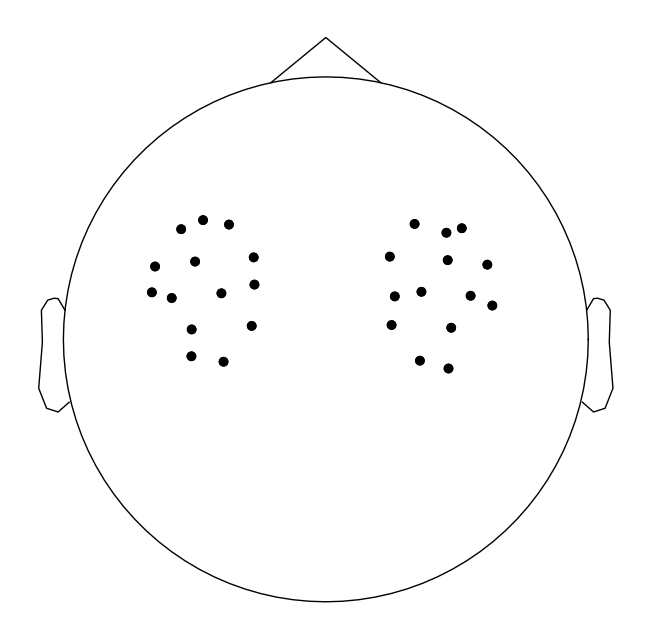

In [12]:
raw_intensity.plot_sensors();

In [13]:
#Part 2
# Correct subjects_dir assignment
subjects_dir = str(mne.datasets.sample.data_path()) + '/subjects'

# Now plotting the alignment
fig = mne.viz.create_3d_figure(size=(800, 600), bgcolor='white')
fig = mne.viz.plot_alignment(
    raw_intensity.info, 
    show_axes=True,
    subject='fsaverage',
    coord_frame='mri',
    trans='fsaverage',
    surfaces=['brain'],
    fnirs=['channels', 'pairs', 'sources', 'detectors'],
    subjects_dir=subjects_dir, 
    fig=fig
)


Using default location ~/mne_data for sample...


 41%|███████████████▋                      | 680M/1.65G [03:12<13:17, 1.22MB/s]Failed to download 'MNE-sample-data-processed.tar.gz'. Will attempt the download again 2 more times.
 41%|███████████████▋                      | 680M/1.65G [03:18<04:44, 3.42MB/s]
Failed to download 'MNE-sample-data-processed.tar.gz'. Will attempt the download again 1 more time.


ConnectTimeout: HTTPSConnectionPool(host='osf.io', port=443): Max retries exceeded with url: /86qa2/download?version=6 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1461db090>, 'Connection to osf.io timed out. (connect timeout=5)'))

In [14]:
events, event_dict = mne.events_from_annotations(raw_intensity, verbose=False)

In [15]:
event_dict = {'Control': 1, 'Tapping/Left': 4, 'Tapping/Right': 3, 'ExperimentEnds': 2}

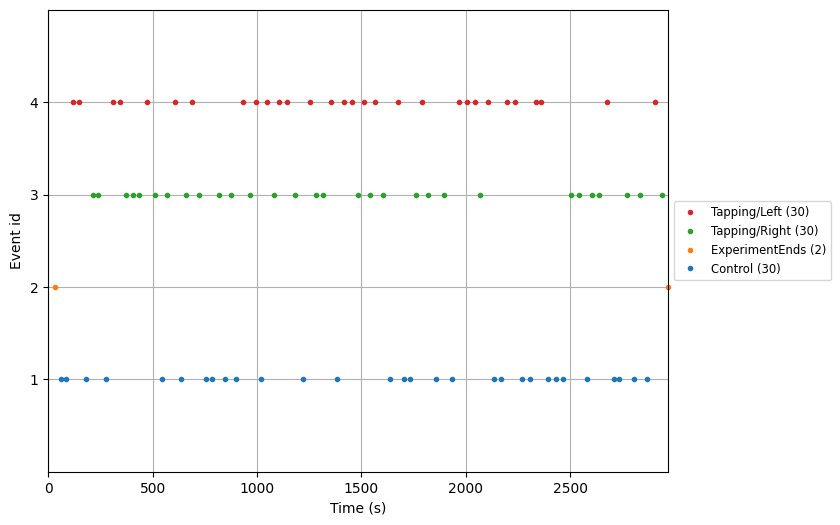

In [16]:
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq']);

In [17]:
%matplotlib qt
raw_intensity.plot(duration = 300, n_channels = len(raw_intensity.ch_names)); 

ImportError: Failed to import any of the following Qt binding modules: PyQt5, PySide2

In [18]:
# putting the plots back in line 
%matplotlib inline 

## Data Manipulation

In [19]:
print(set(raw_intensity.annotations.description))

{'3.0', '2.0', '1.0', '15.0'}


In [20]:
raw_intensity.annotations

<Annotations | 92 segments: 1.0 (30), 15.0 (2), 2.0 (30), 3.0 (30)>

In [21]:
raw_intensity.annotations.delete(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations

<Annotations | 90 segments: 1.0 (30), 2.0 (30), 3.0 (30)>

In [22]:
raw_intensity.annotations.set_durations(5)

<Annotations | 90 segments: 1.0 (30), 2.0 (30), 3.0 (30)>

In [23]:
raw_intensity.annotations.to_data_frame()

,onset,duration,description
0,2019-11-02 13:17:18.391,5.0,1.0
1,2019-11-02 13:17:43.863,5.0,1.0
2,2019-11-02 13:18:14.199,5.0,3.0
3,2019-11-02 13:18:43.383,5.0,3.0
4,2019-11-02 13:19:18.071,5.0,1.0
...,...,...,...
85,2019-11-02 14:03:03.479,5.0,1.0
86,2019-11-02 14:03:29.975,5.0,2.0
87,2019-11-02 14:04:05.943,5.0,1.0
88,2019-11-02 14:04:44.599,5.0,3.0


<Axes: xlabel='onset', ylabel='description'>

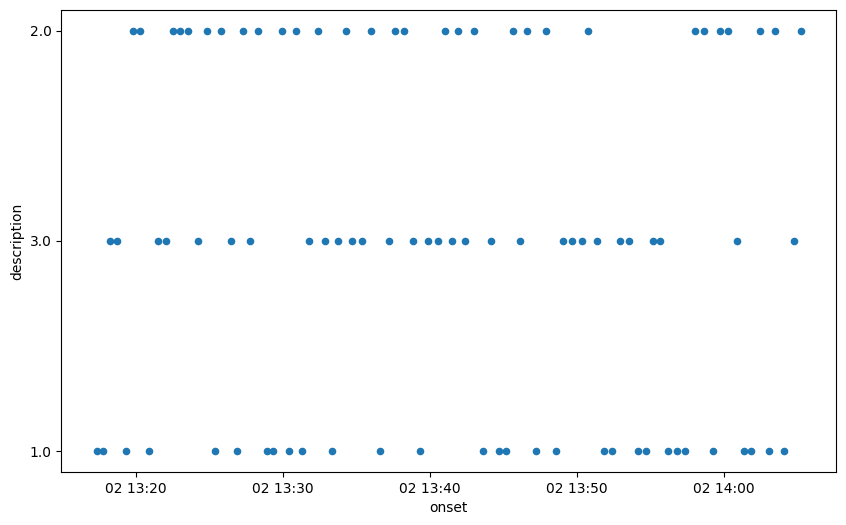

In [24]:
raw_intensity.annotations.to_data_frame().plot.scatter(x='onset',  y='description')

In [25]:
raw = raw_intensity.copy()

In [26]:
raw

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,56 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


In [27]:
#Selecting some channels
raw.copy().pick(picks=[0, 1, 2, 3])

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,4 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


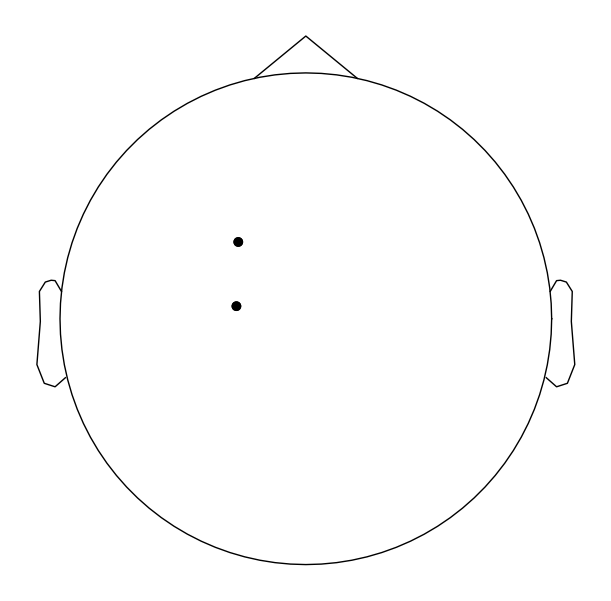

In [28]:
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)
raw.copy().pick(picks=[0, 1, 2, 3]).plot_sensors();

Using matplotlib as 2D backend.


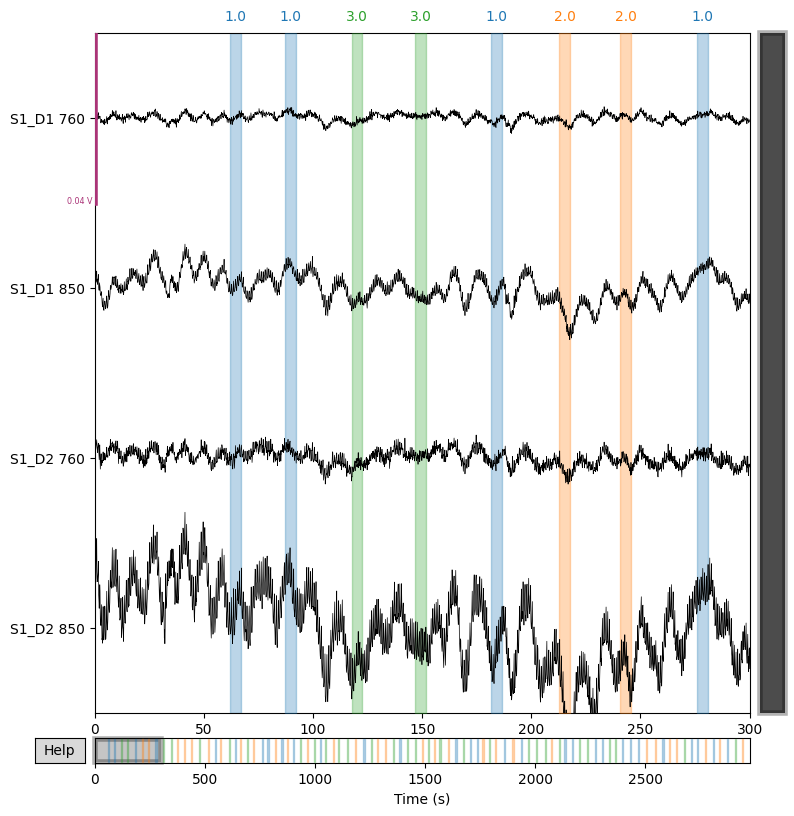

In [29]:
plt.rcParams["figure.figsize"] = (16, 6) # (w, h)
raw.copy().pick(picks=[0, 1, 2, 3]).plot(duration=300);

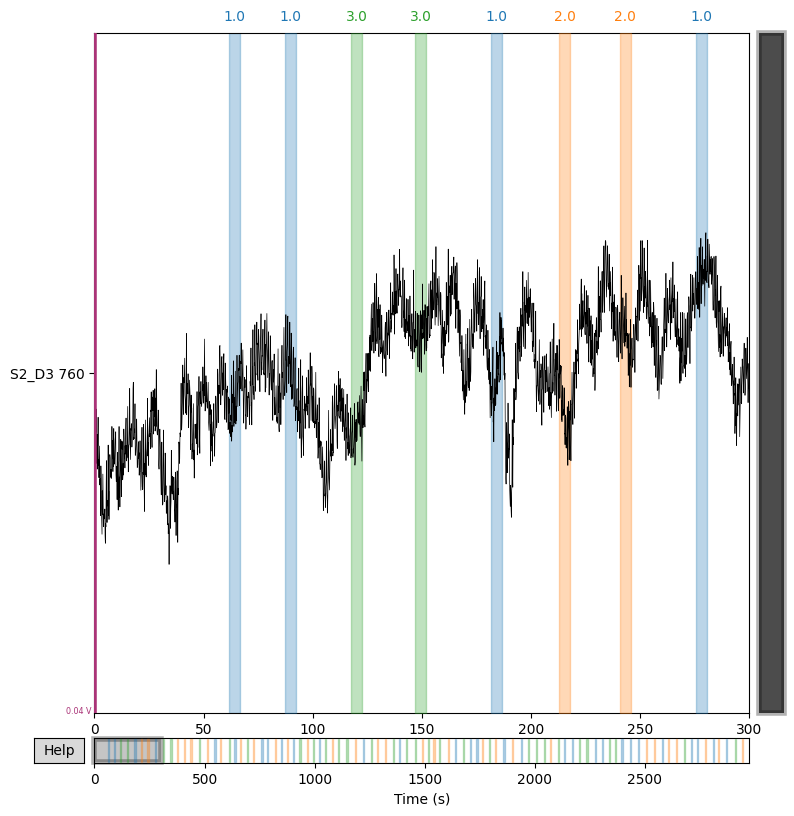

In [30]:
raw.copy().pick(picks=[10]).plot(duration=300);

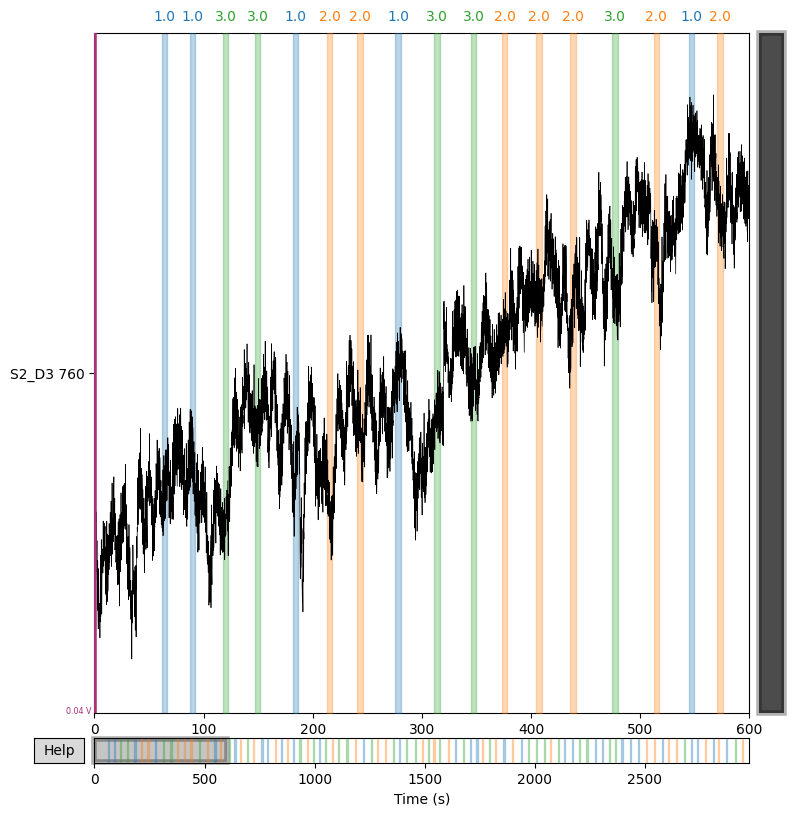

In [31]:
raw.copy().pick(picks=[10]).plot(duration=600);

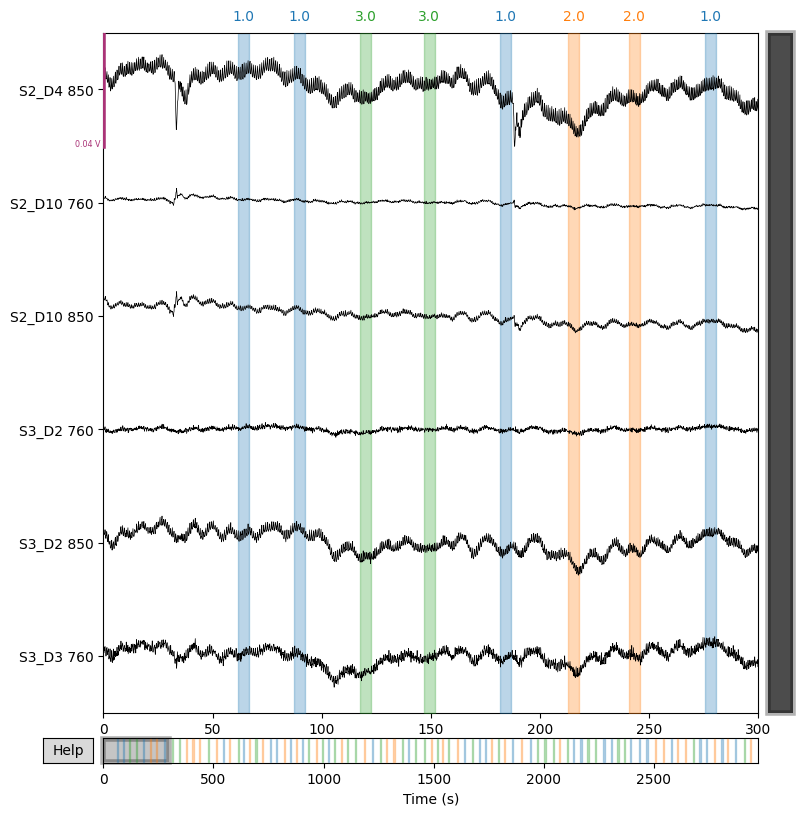

In [32]:
raw.copy().pick(picks=range(13, 19)).plot(duration=300);

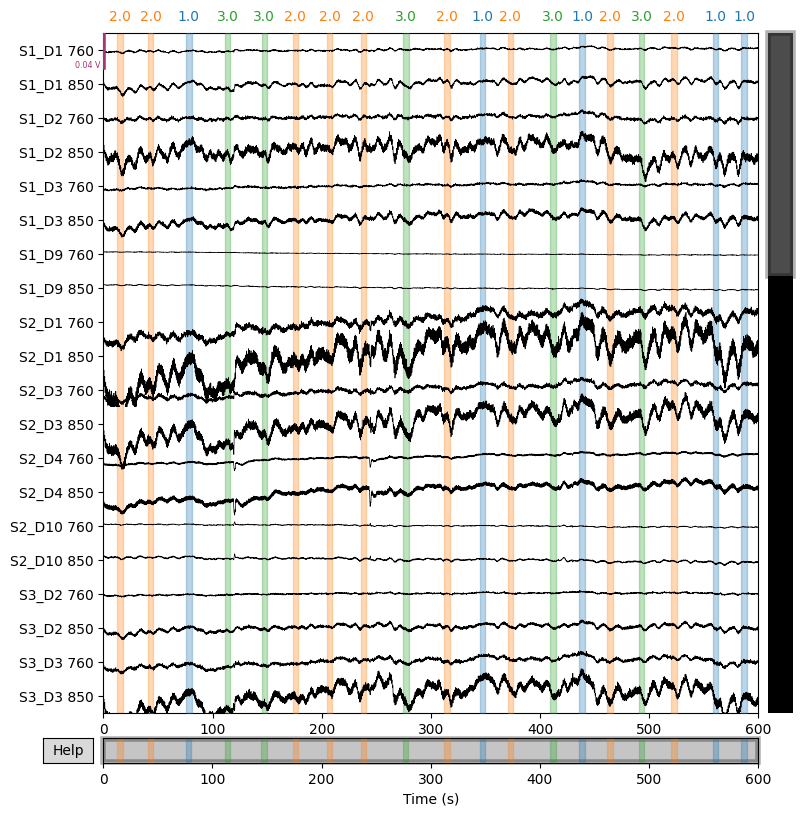

In [33]:
#Cropping data
raw.copy().crop(tmin=200, tmax=800).plot(duration=30000);

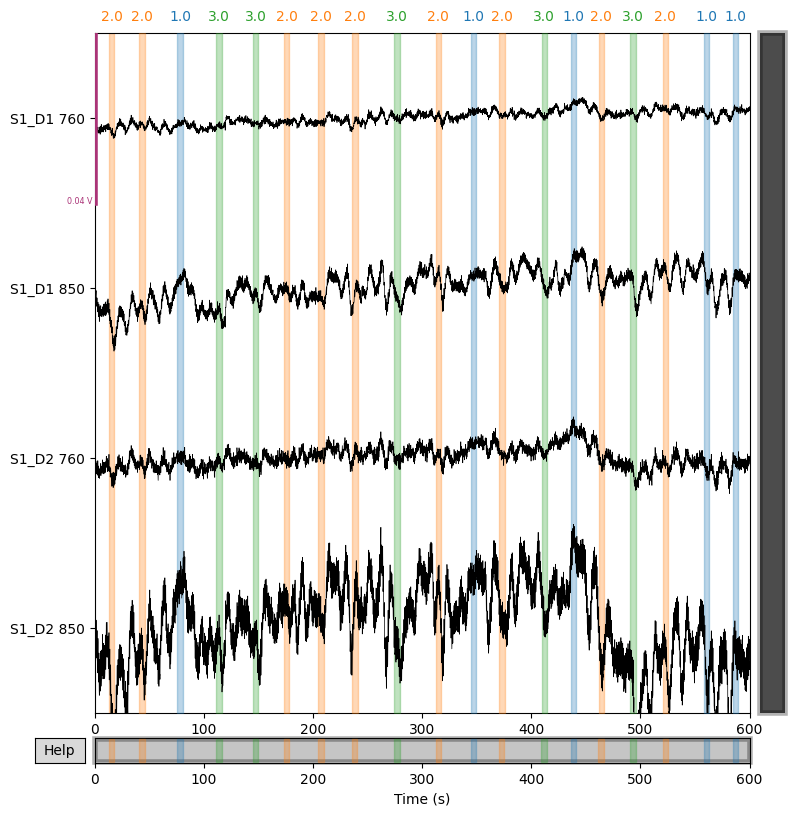

In [34]:
raw.copy().pick(range(4)).crop(tmin=200, tmax=800).plot(duration=30000);

## Signal Processing

In [35]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

In [36]:
raw_od

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,56 fNIRS (OD)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


In [37]:
raw_od.copy().pick(range(6)).ch_names

['S1_D1 760', 'S1_D1 850', 'S1_D2 760', 'S1_D2 850', 'S1_D3 760', 'S1_D3 850']

In [38]:
#Import required functions
from mne.preprocessing.nirs import beer_lambert_law, optical_density

In [39]:
raw_haemo = beer_lambert_law(raw_od)

In [40]:
raw_haemo

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,"28 Oxyhemoglobin, 28 Deoxyhemoglobin"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


In [41]:
raw_haemo.copy().pick(range(6)).ch_names

['S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', 'S1_D3 hbo', 'S1_D3 hbr']

In [42]:
# We can now pick based on type
raw_haemo.copy().pick("hbo").ch_names

['S1_D1 hbo',
 'S1_D2 hbo',
 'S1_D3 hbo',
 'S1_D9 hbo',
 'S2_D1 hbo',
 'S2_D3 hbo',
 'S2_D4 hbo',
 'S2_D10 hbo',
 'S3_D2 hbo',
 'S3_D3 hbo',
 'S3_D11 hbo',
 'S4_D3 hbo',
 'S4_D4 hbo',
 'S4_D12 hbo',
 'S5_D5 hbo',
 'S5_D6 hbo',
 'S5_D7 hbo',
 'S5_D13 hbo',
 'S6_D5 hbo',
 'S6_D7 hbo',
 'S6_D8 hbo',
 'S6_D14 hbo',
 'S7_D6 hbo',
 'S7_D7 hbo',
 'S7_D15 hbo',
 'S8_D7 hbo',
 'S8_D8 hbo',
 'S8_D16 hbo']

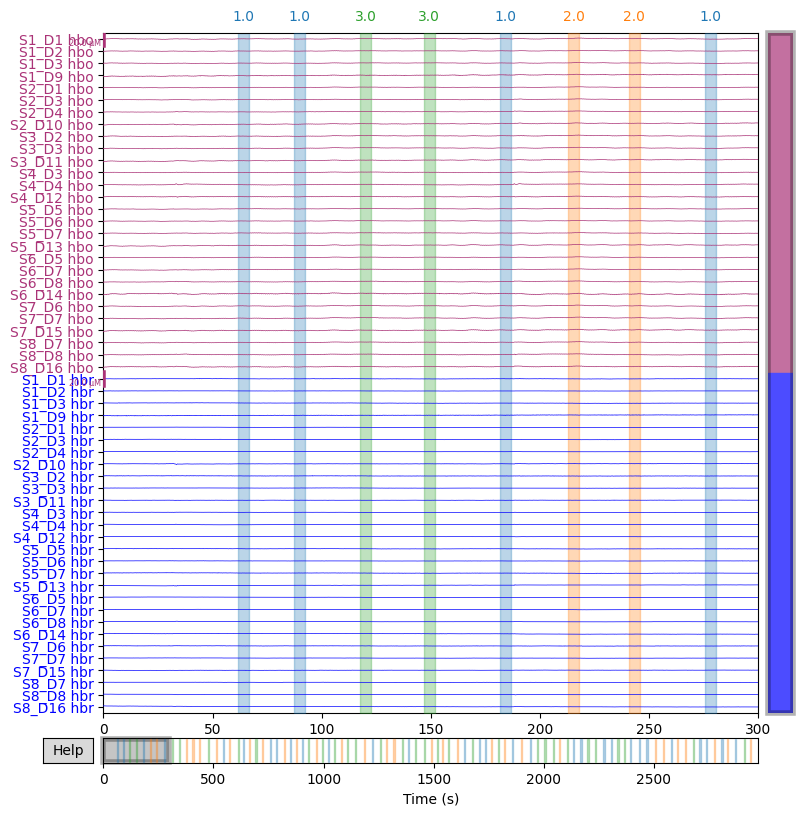

In [43]:
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
raw_haemo.plot(duration=300, n_channels=len(raw_haemo.ch_names), clipping=None);

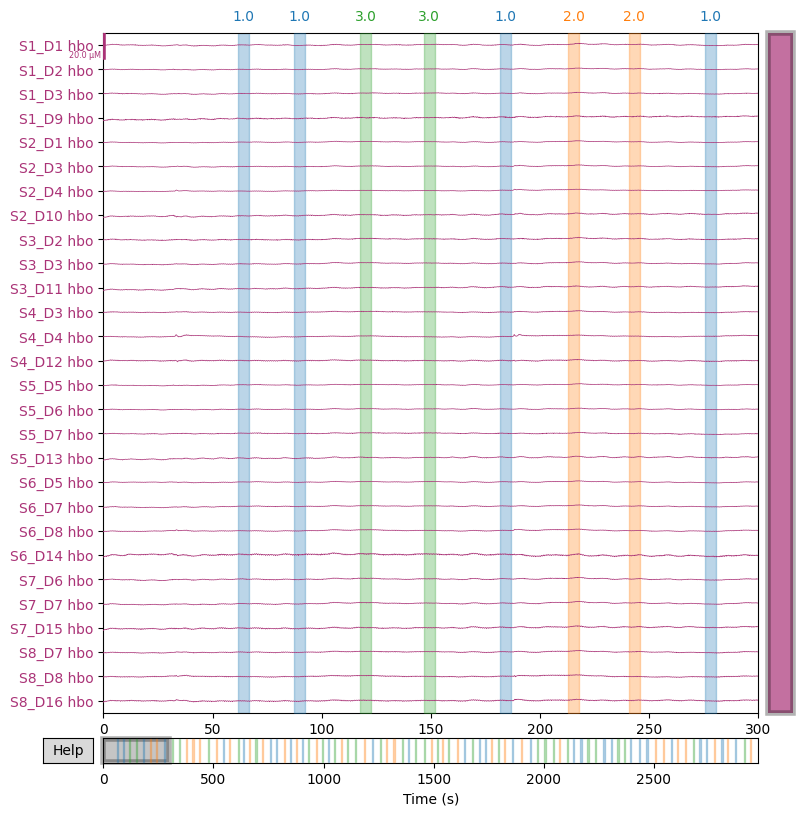

In [44]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
raw_haemo.copy().pick("hbo").plot(duration=300, n_channels=len(raw_haemo.ch_names), clipping=None);

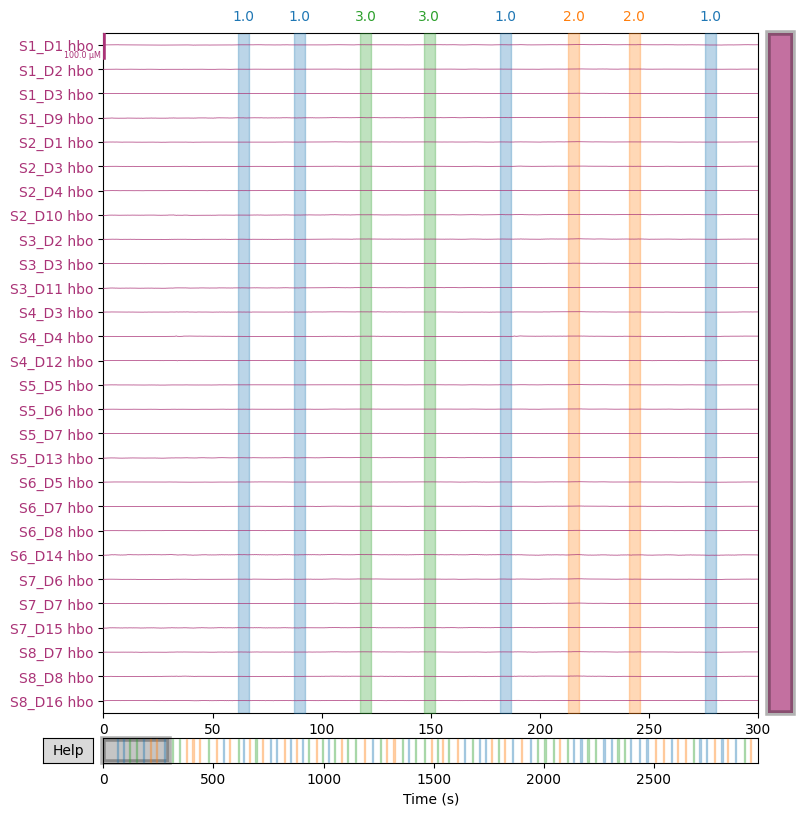

In [45]:
# Changing the scale
raw_haemo.copy().pick("hbo").plot(duration=300, n_channels=len(raw_haemo.ch_names), clipping=None, scalings=dict(hbo=5e-5));

## Data Quality 

In [46]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
sci

array([0.64451388, 0.64451388, 0.82855814, 0.82855814, 0.73965774,
       0.73965774, 0.58274491, 0.58274491, 0.9536225 , 0.9536225 ,
       0.88337935, 0.88337935, 0.98409562, 0.98409562, 0.92169739,
       0.92169739, 0.67823929, 0.67823929, 0.87238821, 0.87238821,
       0.8636861 , 0.8636861 , 0.94439075, 0.94439075, 0.98238431,
       0.98238431, 0.97920112, 0.97920112, 0.61204262, 0.61204262,
       0.77762416, 0.77762416, 0.67654918, 0.67654918, 0.90613474,
       0.90613474, 0.95180484, 0.95180484, 0.93318584, 0.93318584,
       0.97626613, 0.97626613, 0.94300376, 0.94300376, 0.74896185,
       0.74896185, 0.92355509, 0.92355509, 0.9316356 , 0.9316356 ,
       0.93526179, 0.93526179, 0.97442709, 0.97442709, 0.97223285,
       0.97223285])

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

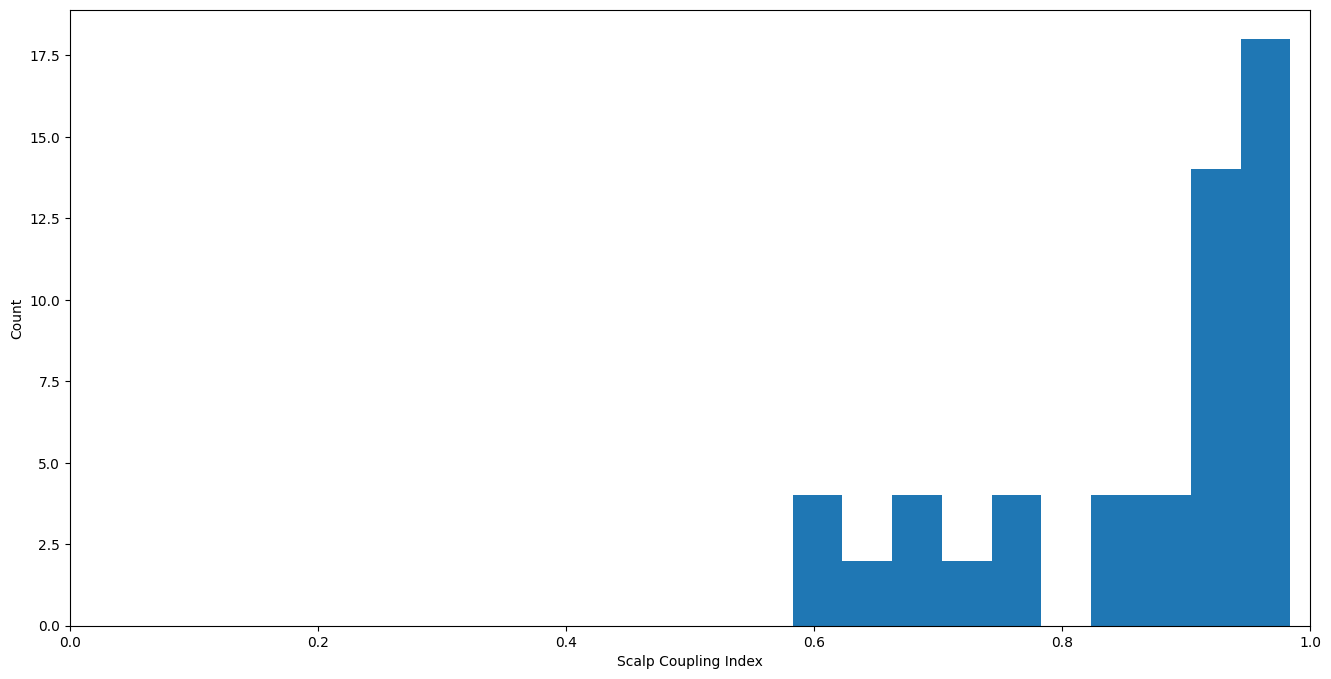

In [47]:
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

In [48]:
# Manual setting of bad channels
raw_od.info['bads'] = ['S1_D9 760', 'S1_D9 850']

In [49]:
raw_od

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,54 fNIRS (OD)
Bad channels,"S1_D9 760, S1_D9 850"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


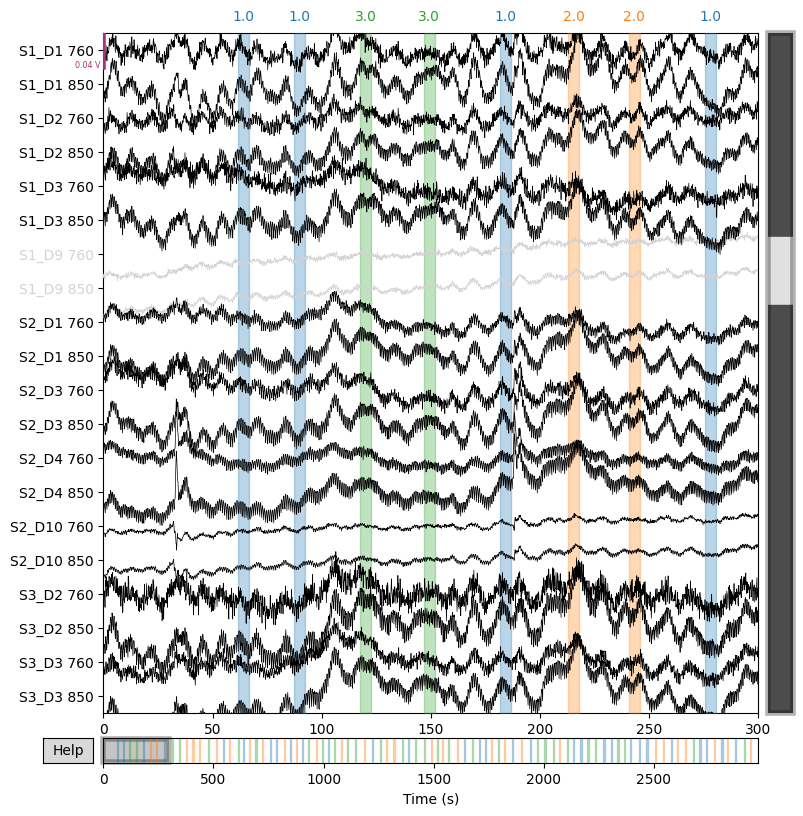

In [50]:
raw_od.copy().pick(range(20)).plot(duration=300, n_channels=len(raw_od.ch_names), clipping=None);

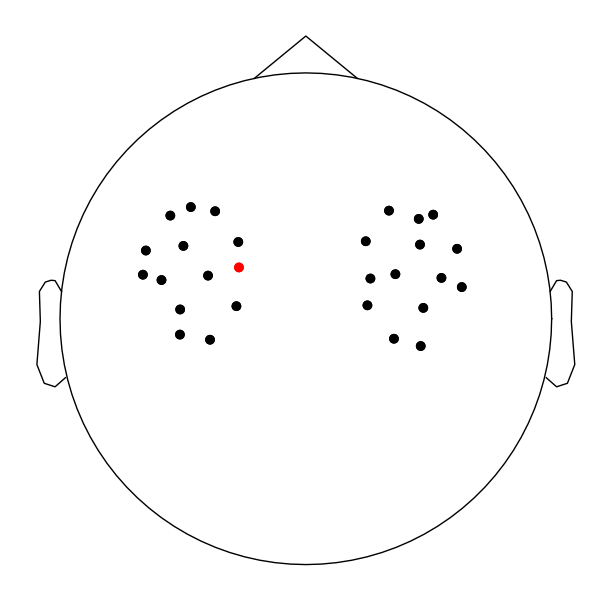

In [51]:
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)
raw_od.plot_sensors();

In [54]:
bad_channels = [ch for ch, val in zip(raw_od.ch_names, sci) if val < 0.6]
raw_od.info['bads'] = bad_channels

In [55]:
raw_od

Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,54 fNIRS (OD)
Bad channels,"S1_D9 760, S1_D9 850"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


In [56]:
# Run sci just on first 30 seconds of data
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od.copy().crop(tmax=30))

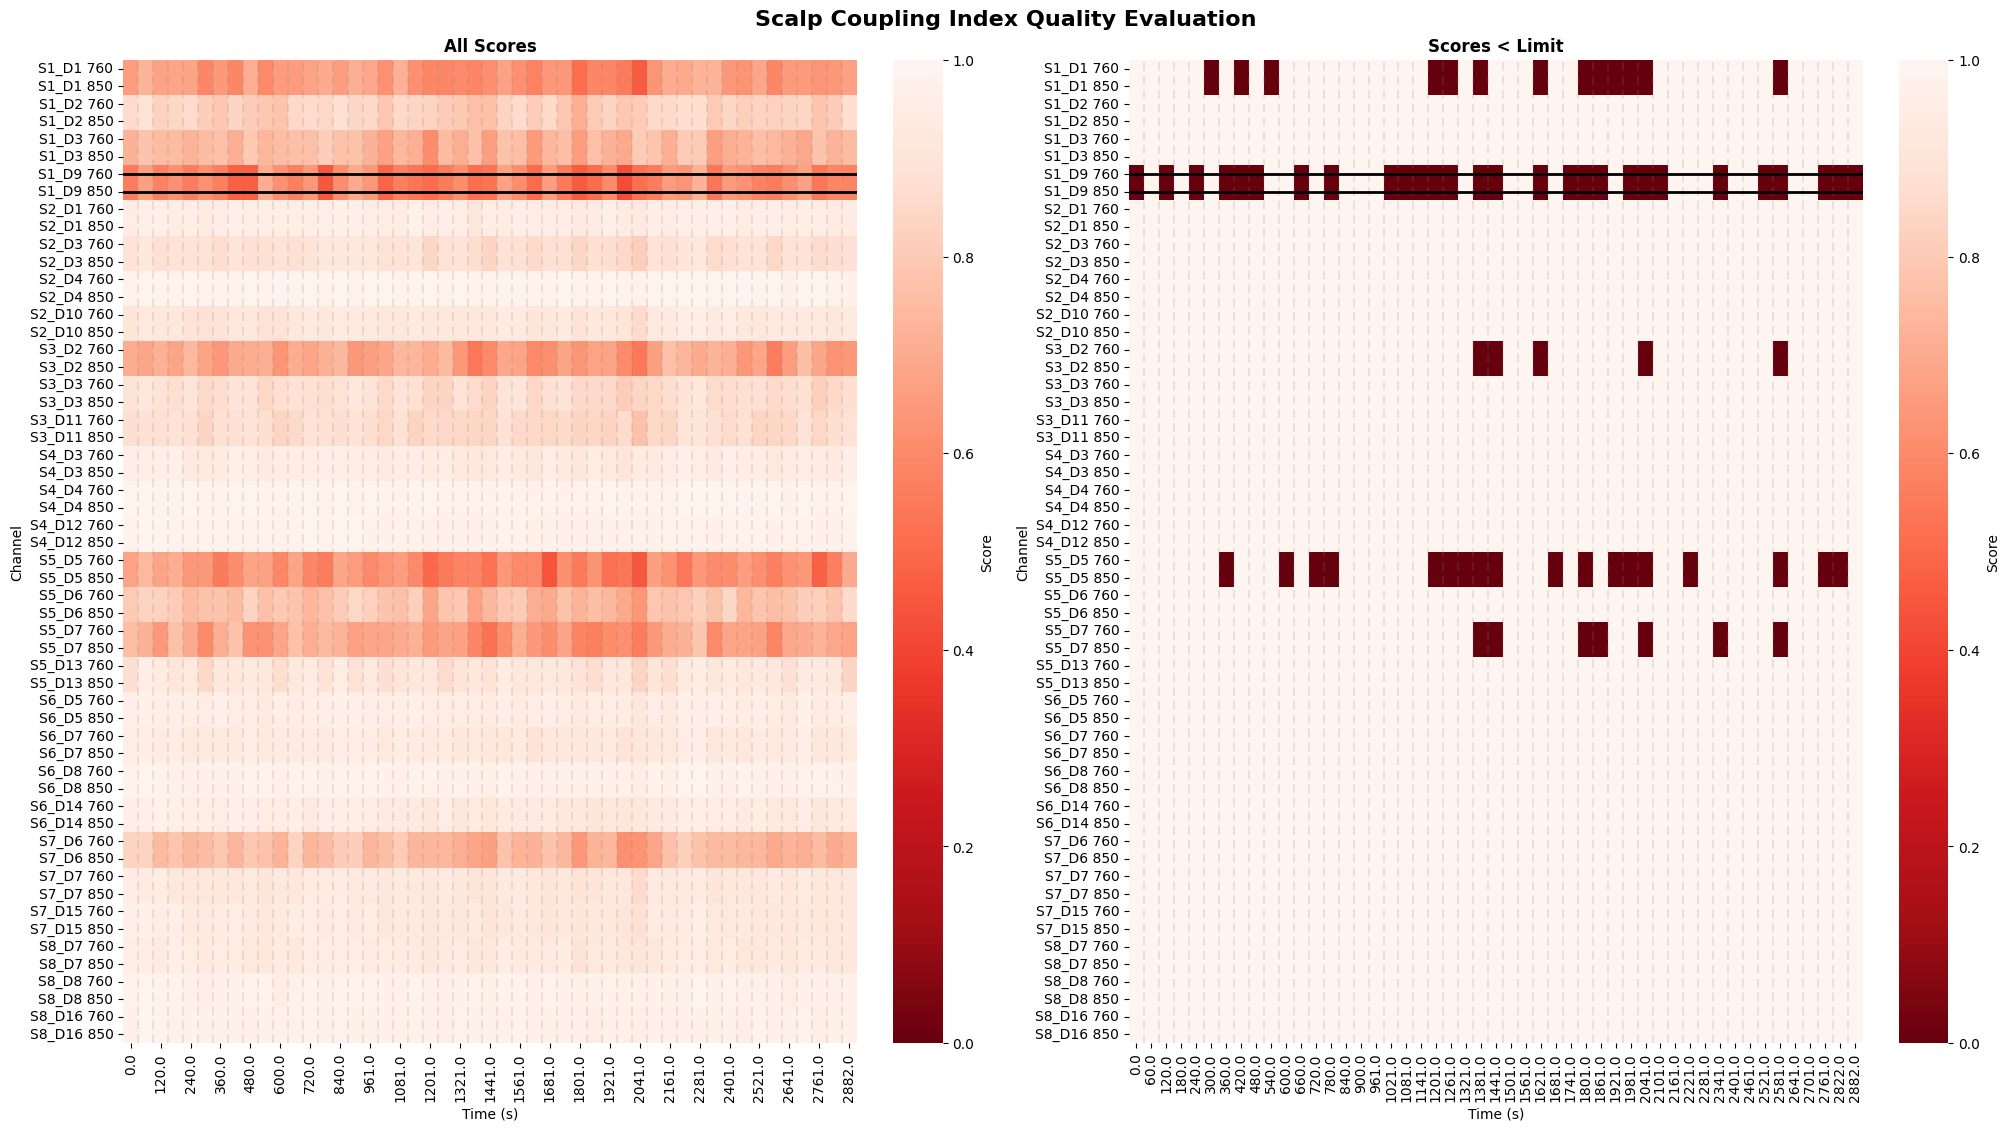

In [57]:
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed
from mne_nirs.visualisation import plot_timechannel_quality_metric

_, scores, times = scalp_coupling_index_windowed(raw_od, time_window=60)
plot_timechannel_quality_metric(raw_od, scores, times, threshold=0.6,
                                title="Scalp Coupling Index "
                                      "Quality Evaluation");

## Preprocessing the Data

In [59]:
#Alternative data format - BIDS file
from mne_bids import BIDSPath, read_raw_bids
from mne_nirs.datasets import fnirs_motor_group

bids_path = BIDSPath(subject="01", task="tapping",
                     root=fnirs_motor_group.data_path(),
                     datatype="nirs", suffix="nirs", extension=".snirf")


Using default location ~/mne_data for fnirs_motor_group...


0.00B [00:00, ?B/s]     
Unzipping contents of '/Users/tevaughnshaw/mne_data/BIDS-NIRS-Tapping-master.zip' to '/Users/tevaughnshaw/mne_data/./fNIRS-motor-group'


Download complete in 06s (41.7 MB)


In [60]:
raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


In [61]:
raw_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

In [62]:
raw_haemo

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Measurement date,"January 01, 2020 13:16:16 GMT"
Experimenter,mne_anonymize
Participant,sub-01
Digitized points,31 points
Good channels,"20 Oxyhemoglobin, 20 Deoxyhemoglobin"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_1067/863735570.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemo.plot_psd(average=True);
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


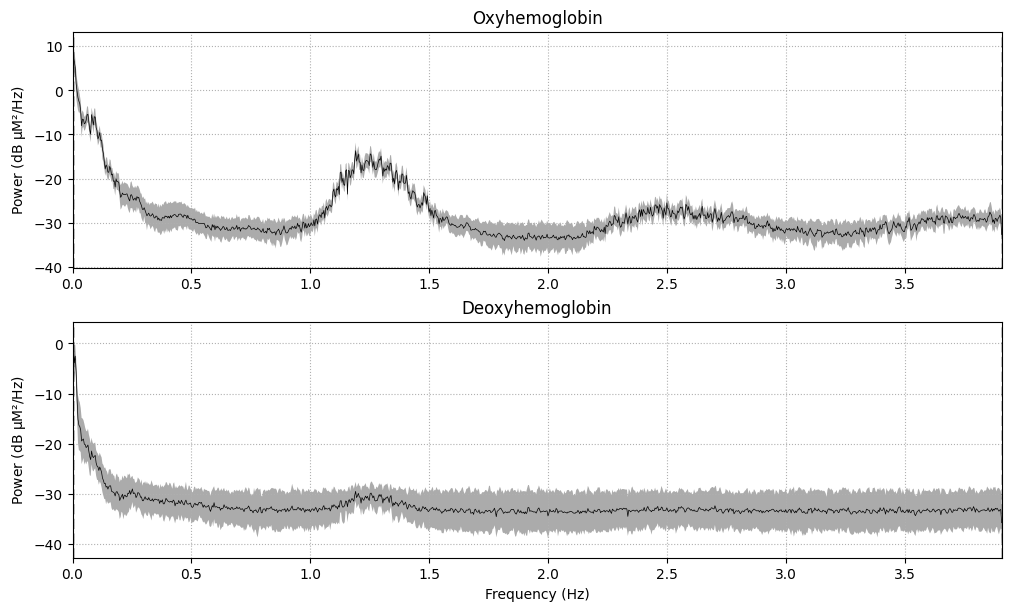

In [63]:
raw_haemo.plot_psd(average=True);

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_1067/1630303790.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemo.compute_psd().plot(average=False);
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


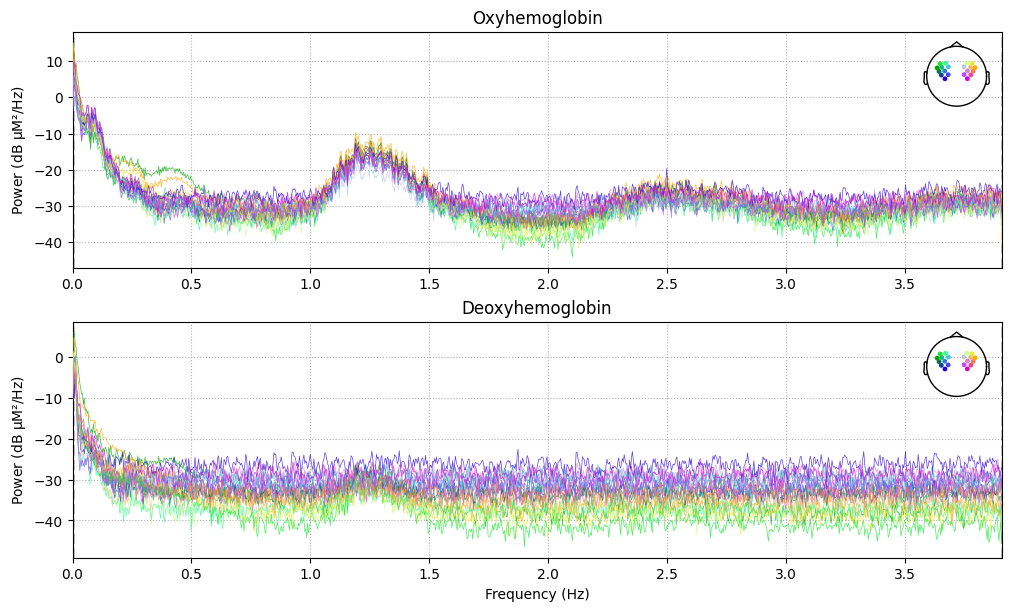

In [64]:
#Filtering the data
plt.rcParams["figure.figsize"] = (16, 14) # (w, h)
raw_haemo.compute_psd().plot(average=False);

In [65]:
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_1067/863735570.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_haemo.plot_psd(average=True);
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


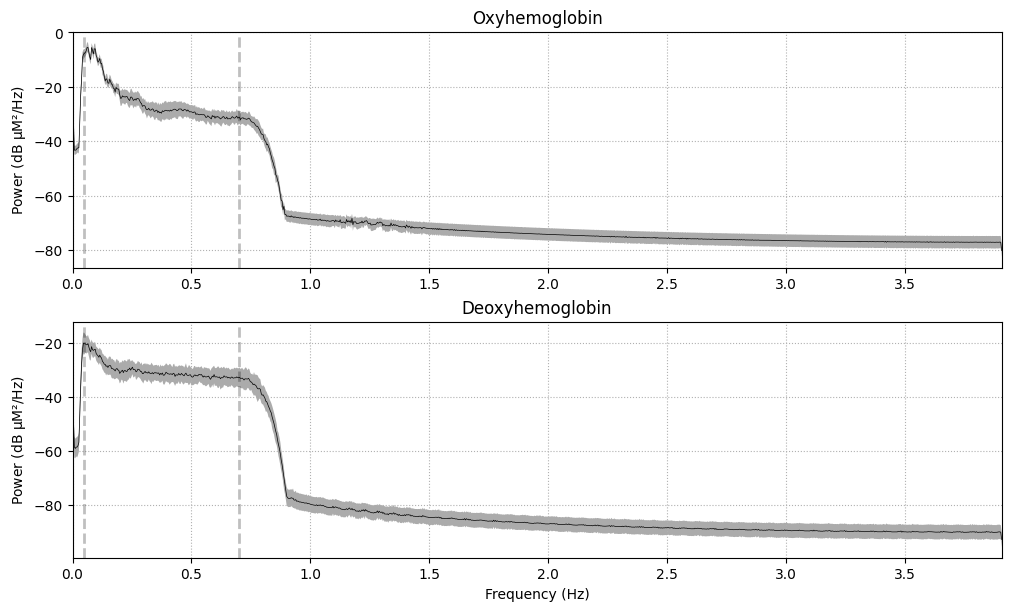

In [66]:
raw_haemo.plot_psd(average=True);

## Epoching

In [67]:
raw_haemo.set_annotations(raw_haemo.annotations[raw_haemo.annotations.description != '15.0'])
events, event_id = mne.events_from_annotations(raw_haemo)

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']


In [68]:
event_dict = {'Control': 1, 'Tapping/Left': 4, 'Tapping/Right': 3, 'ExperimentEnds': 2}

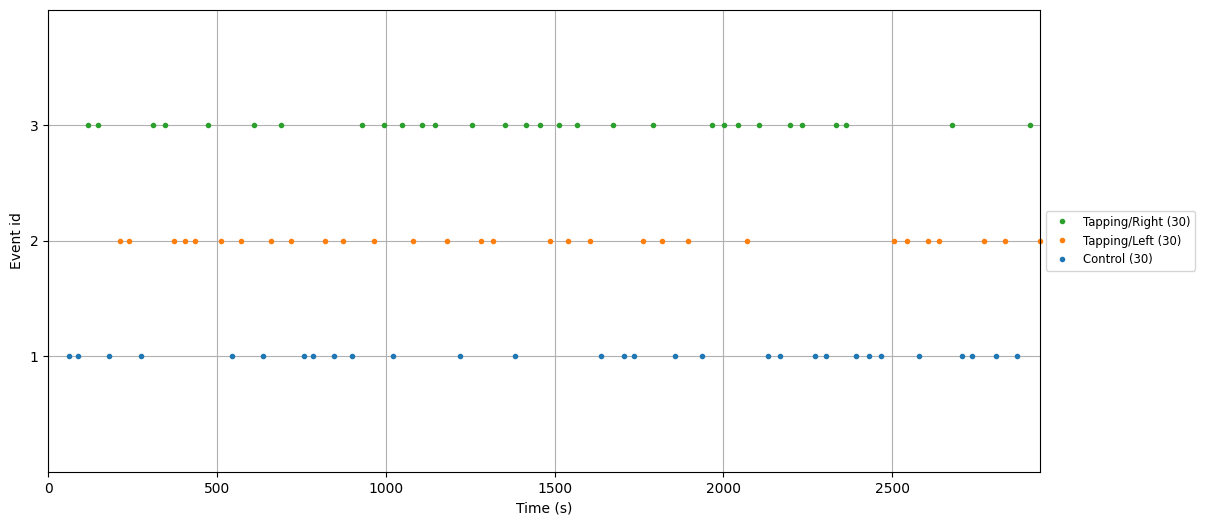

In [69]:
plt.rcParams["figure.figsize"] = (16, 6) # (w, h)

fig = mne.viz.plot_events(events, event_id=event_id, sfreq=raw_haemo.info['sfreq'])

In [70]:
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -5, 15

epochs = mne.Epochs(raw_haemo, events, event_id=event_id,
                    tmin=tmin, tmax=tmax, preload=True,
                    reject=reject_criteria, reject_by_annotation=True)

Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
0 bad epochs dropped


In [71]:
epochs

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Number of events,90
Events,Control: 30Tapping/Left: 30Tapping/Right: 30
Time range,-4.992 – 14.976 s
Baseline,-4.992 – 0.000 s


In [72]:
epochs['Tapping']

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Number of events,60
Events,Tapping/Left: 30Tapping/Right: 30
Time range,-4.992 – 14.976 s
Baseline,-4.992 – 0.000 s


In [73]:
epochs['Tapping/Right']

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Number of events,30
Events,Tapping/Right: 30
Time range,-4.992 – 14.976 s
Baseline,-4.992 – 0.000 s


In [74]:
epochs['Tapping/Right'].average()

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Condition,Tapping/Right
Data kind,average
Timepoints,157 samples
Channels,40 channels
Number of averaged epochs,30
Time range (secs),-4.992 – 14.976
Baseline (secs),-4.992 – 0.000 s


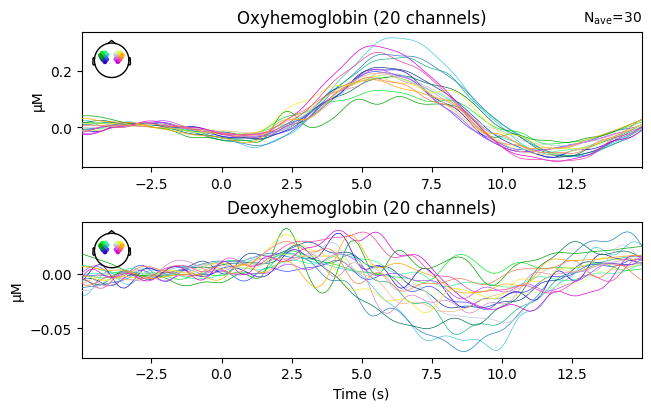

In [75]:
epochs['Tapping/Right'].average().plot();

In [76]:
evoked = epochs['Tapping/Right'].average()

## Plotting

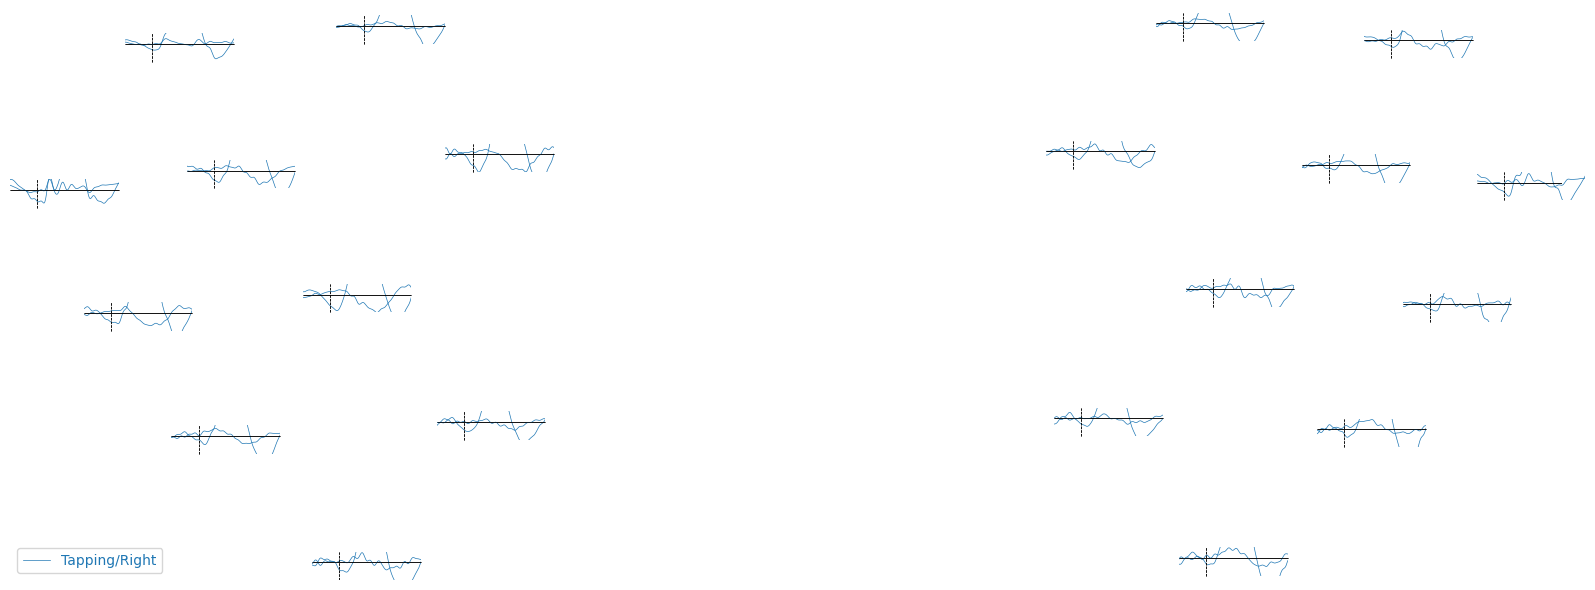

In [77]:
evoked.plot_topo();

No projector specified for this dataset. Please consider the method self.add_proj.


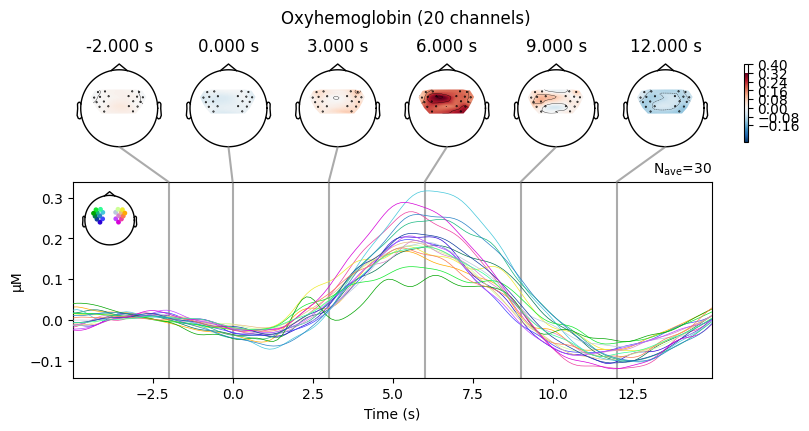

In [78]:
evoked.pick(picks='hbo').plot_joint(times=[-2, 0, 3, 6, 9, 12], topomap_args=dict(extrapolate='local'));

combining channels using "mean"


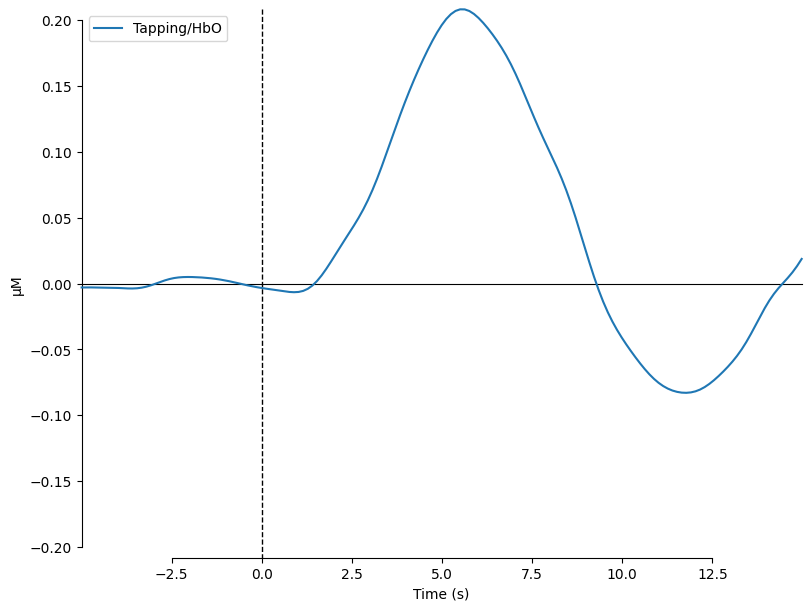

[<Figure size 800x600 with 1 Axes>]

In [79]:
evoked_dict = {'Tapping/HbO': epochs['Tapping'].average(picks='hbo').rename_channels(lambda x: x[:-4])}

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean")

In [80]:
evoked_dict

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


{'Tapping/HbO': <Evoked | '0.50 × Tapping/Left + 0.50 × Tapping/Right' (average, N=60), -4.992 – 14.976 s, baseline -4.992 – 0 s, 20 ch, ~None>}

In [81]:
evoked_dict = {'Tapping/HbO': epochs['Tapping'].average(picks='hbo'),
               'Tapping/HbR': epochs['Tapping'].average(picks='hbr'),
               'Control/HbO': epochs['Control'].average(picks='hbo'),
               'Control/HbR': epochs['Control'].average(picks='hbr')}
evoked_dict

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)
/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


{'Tapping/HbO': <Evoked | '0.50 × Tapping/Left + 0.50 × Tapping/Right' (average, N=60), -4.992 – 14.976 s, baseline -4.992 – 0 s, 20 ch, ~None>,
 'Tapping/HbR': <Evoked | '0.50 × Tapping/Left + 0.50 × Tapping/Right' (average, N=60), -4.992 – 14.976 s, baseline -4.992 – 0 s, 20 ch, ~None>,
 'Control/HbO': <Evoked | 'Control' (average, N=30), -4.992 – 14.976 s, baseline -4.992 – 0 s, 20 ch, ~None>,
 'Control/HbR': <Evoked | 'Control' (average, N=30), -4.992 – 14.976 s, baseline -4.992 – 0 s, 20 ch, ~None>}

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


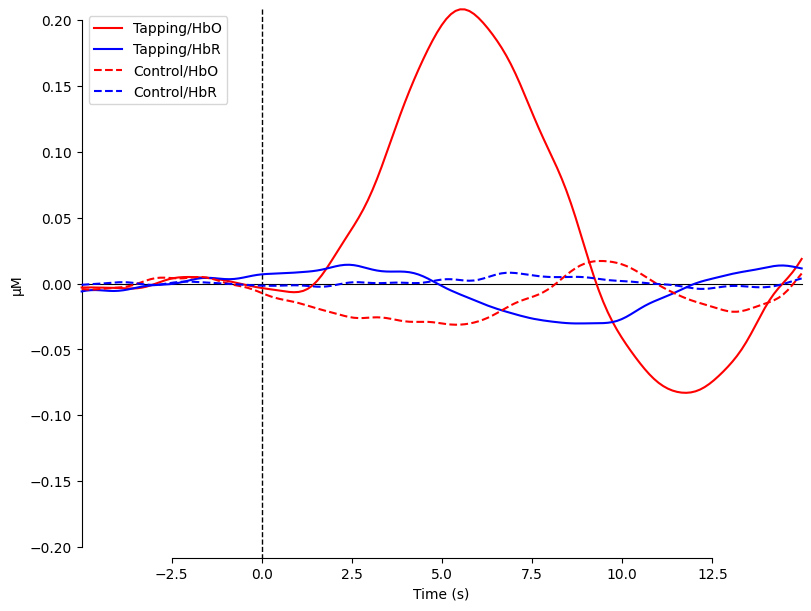

[<Figure size 800x600 with 1 Axes>]

In [82]:
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='r', HbR='b')
styles_dict = dict(Control=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", colors=color_dict, styles=styles_dict)

## Statistical Summary & Comparison

In [83]:
epochs["Tapping"]

/Users/tevaughnshaw/basicenv/lib/python3.11/site-packages/IPython/lib/pretty.py:778: RuntimeWarning: Could not get size for self.info
  output = repr(obj)


Number of events,60
Events,Tapping/Left: 30Tapping/Right: 30
Time range,-4.992 – 14.976 s
Baseline,-4.992 – 0.000 s


In [84]:
import pandas as pd

results = pd.DataFrame()

for epoch in epochs["Tapping"].copy().pick("hbo").crop(tmin=4, tmax=6):
    row = pd.DataFrame([{"Value": epoch.mean() * 1e6, "Condition": "Tapping"}])
    results = pd.concat([results, row], ignore_index=True)


In [85]:
results.tail()

,Value,Condition
55,0.446507,Tapping
56,0.250667,Tapping
57,0.198014,Tapping
58,0.046029,Tapping
59,0.242566,Tapping


In [86]:
for epoch in epochs["Control"].copy().pick("hbo").crop(tmin=4, tmax=6):
    row = pd.DataFrame([{"Value": epoch.mean() * 1e6, "Condition": "Control"}])
    results = pd.concat([results, row], ignore_index=True)

In [87]:
results["ID"] = "P01"

In [88]:
results

,Value,Condition,ID
0,0.211323,Tapping,P01
1,0.003505,Tapping,P01
2,0.370860,Tapping,P01
3,0.184992,Tapping,P01
4,0.140125,Tapping,P01
...,...,...,...
85,0.145702,Control,P01
86,-0.110272,Control,P01
87,0.190183,Control,P01
88,-0.062807,Control,P01


In [89]:
#Statistical comparison of conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [90]:
control_data = results[results['Condition'] == 'Control']['Value']

In [91]:
control_data

60   -0.049591
61   -0.093194
62   -0.012694
63   -0.152343
64   -0.109926
65   -0.145193
66    0.172304
67   -0.310087
68   -0.199271
69   -0.103491
70    0.085759
71    0.088719
72   -0.113525
73    0.022164
74    0.219801
75    0.114955
76   -0.201535
77   -0.104935
78   -0.066836
79    0.023751
80   -0.069669
81   -0.202611
82   -0.259259
83    0.060163
84   -0.089491
85    0.145702
86   -0.110272
87    0.190183
88   -0.062807
89    0.437148
Name: Value, dtype: float64

In [92]:
tapping_data = results[results['Condition'] == 'Tapping']['Value']

In [93]:
tapping_data

0     0.211323
1     0.003505
2     0.370860
3     0.184992
4     0.140125
5     0.155250
6     0.062610
7     0.247846
8    -0.152262
9     0.317456
10    0.189949
11    0.350546
12    0.312643
13    0.346031
14    0.376260
15    0.266805
16    0.306804
17    0.197094
18    0.110850
19    0.169188
20   -0.176214
21    0.321315
22    0.238002
23    0.746656
24    0.189235
25    0.545866
26    0.283465
27    0.118851
28    0.322840
29   -0.047172
30   -0.000548
31    0.064399
32   -0.294819
33    0.139773
34    0.351645
35    0.270127
36    0.016849
37    0.207489
38   -0.015900
39   -0.028557
40    0.247392
41    0.144274
42    0.288011
43    0.033315
44    0.127174
45    0.271453
46    0.259307
47    0.071791
48    0.179349
49    0.214610
50   -0.095519
51    0.240260
52    0.270496
53    0.187456
54    0.119648
55    0.446507
56    0.250667
57    0.198014
58    0.046029
59    0.242566
Name: Value, dtype: float64

In [94]:
mean_control = np.mean(control_data)
mean_tapping = np.mean(tapping_data)
mean_diff = mean_tapping - mean_control

In [95]:
mean_control

-0.029869272662896244

In [96]:
mean_tapping

0.18606628020739285

In [97]:
mean_diff

0.2159355528702891

/var/folders/_7/61vbt98120v7tjjx9b62g2ph0000gn/T/ipykernel_1067/3734416498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='Condition', y='Value', data=results, palette={"Control": "orange", "Tapping": "lightblue"})


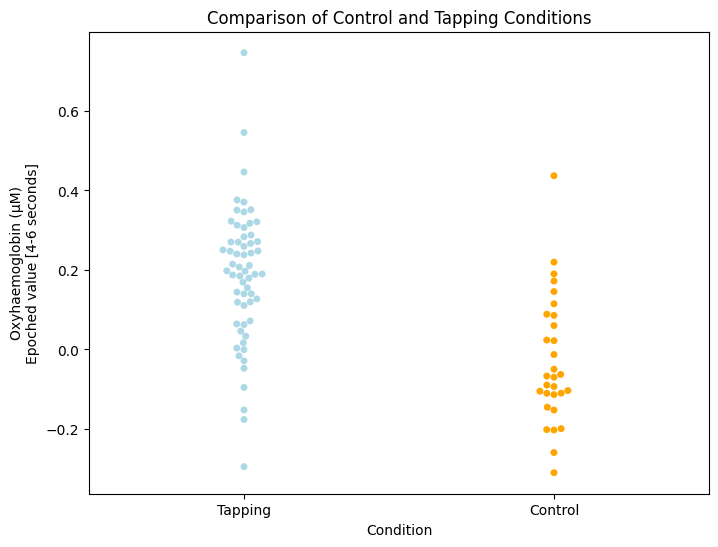

In [98]:
plt.figure(figsize=(8, 6))
sns.swarmplot(x='Condition', y='Value', data=results, palette={"Control": "orange", "Tapping": "lightblue"})
plt.ylabel('Oxyhaemoglobin (µM)\nEpoched value [4-6 seconds]')
plt.title('Comparison of Control and Tapping Conditions')
plt.show()

In [99]:
t_stat, p_value = stats.ttest_ind(control_data, tapping_data)

In [100]:
print(f'Mean Difference (Tapping - Control): {mean_diff:.2f} µM')

print(f'T-statistic: {t_stat:.3f}')
print(f'P-value: {p_value:.3f}')

Mean Difference (Tapping - Control): 0.22 µM
T-statistic: -5.750
P-value: 0.000


### Traditional Stats

In [101]:
from scipy import stats

In [102]:
results_tapping = results.query('Condition == "Tapping"').Value
results_control = results.query('Condition == "Control"').Value

In [103]:
stats.ttest_1samp(results_tapping, 0.0)

TtestResult(statistic=8.420449171307, pvalue=1.0682726274751085e-11, df=59)

In [104]:
stats.ttest_1samp(results_control, 0.0)

TtestResult(statistic=-1.0150692925418217, pvalue=0.3184672734937245, df=29)